In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt

#(8) learning rate decay
from torch.optim import lr_scheduler

batch_size=64
learning_rate=0.001
num_epoch=10

In [2]:
cifar_train=dset.CIFAR10("CIFAR10/",train=True, transform=transforms.ToTensor(),target_transform=None, download=True)
cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(),target_transform=None, download=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True,
                        transform=transforms.Compose([
                            transforms.Scale(36),
                            transforms.CenterCrop(32),
                            transforms.RandomHorizontalFlip(),
                            transforms.Lambda(lambda x: x.rotate(90)),
                            transforms.ToTensor()
                        ]))
cifar_test=dset.CIFAR10("CIFAR10/",train=False, transform=transforms.ToTensor(),target_transform=None, download=True)

Files already downloaded and verified


In [5]:
cifar_train=dset.CIFAR10("CIFAR10/", train=True,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        ])
                         , target_transform=None, download=False)
                        
cifar_test=dset.CIFAR10("CIFAR10/", train=False,
                        transform=transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5)),
                        ])
                         , target_transform=None, download=False)

cifar_train 길이: 50000
cifar_test 길이: 10000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image data 형태: torch.Size([3, 32, 32])
label:  9


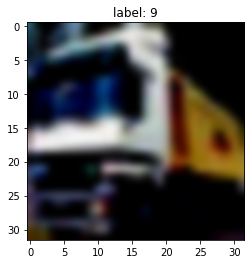

In [6]:
print("cifar_train 길이:", len(cifar_train))
print("cifar_test 길이:", len(cifar_test))

#데이터 하나 형태
image, label = cifar_train.__getitem__(1) #1번째 데이터
print("image data 형태:", image.size())
print("label: ", label)

#그리기
img = image.numpy() #image 타입을 numpy로 변환 (3,32,32)

#(3,32,32) -> (32,32,3)
r,g,b = img[0,:,:], img[1,:,:], img[2,:,:]
#img = img.reshape(img.shape[1], img.shape[2], img.shape[0])
img2 = np.zeros((img.shape[1], img.shape[2], img.shape[0]))
img2[:,:,0], img2[:,:,1], img2[:,:,2] = r,g,b

plt.title("label: %d" %label)
plt.imshow(img2,interpolation='bicubic')
plt.show()

In [10]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader): #batch_size 만큼
        with torch.no_grad():
            img = imgs
            label = labels
        
        #--img = Variable(imgs,volatile=True).cuda() #.cuda #x
        #label = Variable(labels) #y
        #--label = Variable(labels).cuda() #.cuda()
        # .cuda() : GPU에 로드되기 위함. 만약 GPU로 설정되어 있다면 에러남
        
        output = imodel.forward(img) #forward prop.
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data:{}".format(100*correct/total))

In [7]:
# === 3. 데이터 로드함수 ===
train_loader=torch.utils.data.DataLoader(list(cifar_train)[:], batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader=torch.utils.data.DataLoader(cifar_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# === 4. 모델 선언 ===
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.layer=nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
                        
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),
            
            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm2d(16), # (6), Batch normalization
           
            nn.Conv2d(16,32,3,padding=1),

            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),
            
            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm2d(32),
           
            nn.MaxPool2d(2,2),
            nn.Conv2d(32,64,3,padding=1),
            
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),
            
            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm2d(64),
            
            nn.MaxPool2d(2,2)       
        )
        self.fc_layer=nn.Sequential(
            nn.Linear(64*8*8, 1024),
            
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),

            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024,512),
            
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),

            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm1d(512),

            nn.Linear(512,256),
            
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),

            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm1d(256),

            nn.Linear(256,124),
            
            nn.ELU(),
            #nn.LeakyReLU(0.1),
            #nn.Tanh(),
            #nn.Sigmoid(),
            #nn.ReLU(),

            #nn.Dropout2d(0.2), # (2) drop out
            nn.Dropout2d(0.15), # (2) drop out
            nn.BatchNorm1d(124),

            nn.Linear(124,10)
        )
        
        
    def forward(self, x):
        out=self.layer(x)
        out=out.view(batch_size, -1)
        out=self.fc_layer(out)
        
        return out
model=CNN() #.cuda()

In [8]:
# === 5. loss, optimizer ===
loss_func=nn.CrossEntropyLoss()
#optimizer=torch.optim.SGD(model.parameters() , lr=learning_rate)
optimizer=torch.optim.Adam(model.parameters(), lr=learning_rate) #(6) Adam optimizer

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.2) #(7) learning rate decay
model.train() #train mode로 바꾸기 -> dropout, batch normalization에 영향을 줌
# === 6. 학습 ===
for i in range(num_epoch):
    for j,[image, label] in enumerate(train_loader):
        #with torch.no_grad():
        #    x = image
        #    y_ = label
        x=Variable(image) #.cuda()
        y_=Variable(label) #.cuda()
        
        optimizer.zero_grad()
        output=model.forward(x)
        loss=loss_func(output,y_)
        loss.backward()
        optimizer.step()
        
        if j%1000==0:
            print(j,loss)

0 tensor(2.3093, grad_fn=<NllLossBackward>)
0 tensor(1.0164, grad_fn=<NllLossBackward>)
0 tensor(0.8358, grad_fn=<NllLossBackward>)
0 tensor(0.8290, grad_fn=<NllLossBackward>)
0 tensor(0.6215, grad_fn=<NllLossBackward>)
0 tensor(0.3344, grad_fn=<NllLossBackward>)
0 tensor(0.4098, grad_fn=<NllLossBackward>)
0 tensor(0.4889, grad_fn=<NllLossBackward>)
0 tensor(0.3752, grad_fn=<NllLossBackward>)
0 tensor(0.1009, grad_fn=<NllLossBackward>)


In [13]:
#학습된 파라미터 저장
netname = './nets/mynet01.pkl'
torch.save(model, netname, )

In [16]:
#저장된 파라미터 로드
netname = './nets/mynet01.pkl'
model = torch.load(netname)

# 성능확인
ComputeAccr(test_loader, model)

Accuracy of Test Data:77.02323913574219


**batchsize = 32 learning_rate=0.002 num_epoch=20**



In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:77.19351196289062


**batchsize = 32 learning_rate=0.0018 num_epoch=20**

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.62259674072266


**batchsize = 32 learning_rate=0.0022 num_epoch=20**

In [ ]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.3621826171875


**batchsize = 32 learning_rate=0.00195 num_epoch=20**

In [13]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.57251739501953


**batchsize = 64 learning_rate=0.001 num_epoch=10**

In [23]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:77.33373260498047


**batchsize = 64 learning_rate=0.001 num_epoch=20**

In [32]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.49238586425781


**batchsize = 64 learning_rate=0.002 num_epoch=20**

In [41]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.7227554321289


**batchsize = 64 learning_rate=0.002 num_epoch=10**


In [50]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.77283477783203


**batchsize = 64 learning_rate=0.0008 num_epoch=10**

In [59]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.81290435791016


**batchsize = 64 learning_rate=0.0001 num_epoch=10**

In [68]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:75.52083587646484


**batchsize = 64 learning_rate=0.0011 num_epoch=10**

In [77]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.49238586425781


첫번째만 nn.LeakyReLU(0.1)

In [80]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:77.04327392578125


**batchsize = 64 learning_rate=0.001 num_epoch=10 nn.LeakyReLU(0.1)**

In [83]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.7528076171875


**batchsize = 64 learning_rate=0.001 num_epoch=10 첫번째만 nn.LeakyReLU(0.1)**

In [87]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.43228912353516


**batchsize = 64 learning_rate=0.001 num_epoch=10 Tanh**

In [90]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:69.70152282714844


**batchsize = 64 learning_rate=0.001 num_epoch=10 Sigmoid**

In [93]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:65.79527282714844


**batchsize = 64 learning_rate=0.001 num_epoch=10 ReLU**

In [96]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:75.7411880493164


**batchsize = 64 learning_rate=0.002 num_epoch=20 ELU**



In [101]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.5925521850586


**batchsize = 64 learning_rate=0.005 num_epoch=50 ELU**

In [106]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.80288696289062


**batchsize = 64 learning_rate=0.003 num_epoch=50 ELU**

In [110]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:77.44390869140625


**batchsize = 64 learning_rate=0.003 num_epoch=100 ELU**

In [114]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:76.78285217285156


In [11]:
model.eval()
ComputeAccr(test_loader,model)

Accuracy of Test Data:77.02323913574219
